In [1]:
%config Completer.use_jedi = False

In [2]:
%matplotlib inline
!pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\program files\python310\lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [3]:
import datetime
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D,LeakyReLU, MaxPooling2D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Extracting Data

In [5]:
#Function to load battery discharge .mat file
def load_data_discharge(battery):
  mat = loadmat('battery_data/' + battery + '.mat')
  print('Total data in dataset ' + battery + ': ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  #print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

In [6]:
#Function to load battery charge .mat file
def load_data_charge(battery):
  mat = loadmat('battery_data/' + battery + '.mat')
  print('Total data in dataset ' + battery + ': ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'charge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_charge = data[0][0]['Current_charge'][0][j]
        voltage_charge = data[0][0]['Voltage_charge'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, 
                        voltage_measured, current_measured,
                        temperature_measured, current_charge,
                        voltage_charge, time])
      counter = counter + 1
  #print(dataset[0])
  return pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_charge', 'voltage_charge', 'time'])

In [30]:
#Load all batteries' discharge and its measured capacity
B0005_discharge, B0005_capacity = load_data_discharge('B0005')
B0006_discharge, B0006_capacity = load_data_discharge('B0006')
B0007_discharge, B0007_capacity = load_data_discharge('B0007')
B0018_discharge, B0018_capacity = load_data_discharge('B0018')

Total data in dataset B0005:  616
Total data in dataset B0006:  616
Total data in dataset B0007:  616
Total data in dataset B0018:  319


In [31]:
#Load all batteries' charge
B0005_charge = load_data_charge('B0005')
B0006_charge = load_data_charge('B0006')
B0007_charge = load_data_charge('B0007')
B0018_charge = load_data_charge('B0018')

Total data in dataset B0005:  616
Total data in dataset B0006:  616
Total data in dataset B0007:  616
Total data in dataset B0018:  319


In [34]:
# Example of read battery's charge data
B0005_charge.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current_charge,voltage_charge,time
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000
1,1,24,2008-04-02 13:08:17,3.479394,-4.030268,24.666480,-4.036,1.570,2.532
2,1,24,2008-04-02 13:08:17,4.000588,1.512731,24.675394,1.500,4.726,5.500
3,1,24,2008-04-02 13:08:17,4.012395,1.509063,24.693865,1.500,4.742,8.344
4,1,24,2008-04-02 13:08:17,4.019708,1.511318,24.705069,1.500,4.753,11.125


In [35]:
# Example of read battery's discharge data
B0005_discharge.head()

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,24,2008-04-02 15:25:41,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000
1,1,24,2008-04-02 15:25:41,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781
2,1,24,2008-04-02 15:25:41,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703
3,1,24,2008-04-02 15:25:41,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781
4,1,24,2008-04-02 15:25:41,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922


# Scaling Data (MinMaxScaler)

In [10]:
scaler = MinMaxScaler()
feature_discharge = ['capacity', 'voltage_measured', 'current_measured', 
                     'temperature_measured', 'current_load', 
                     'voltage_load', 'time']
feature_charge = ['voltage_measured', 'current_measured', 
                  'temperature_measured', 'current_charge', 
                  'voltage_charge', 'time']

B0005_discharge['cell'] = "B0005"
B0006_discharge['cell'] = "B0006"
B0007_discharge['cell'] = "B0007"
B0018_discharge['cell'] = "B0018"

B0005_charge['cell'] = "B0005"
B0006_charge['cell'] = "B0006"
B0007_charge['cell'] = "B0007"
B0018_charge['cell'] = "B0018"

cell_discharge = pd.concat([B0005_discharge, B0006_discharge, B0007_discharge, B0018_discharge])
cell_charge = pd.concat([B0005_charge, B0006_charge, B0007_charge, B0018_charge])

B0005_SOH = B0005_capacity['capacity']/B0005_capacity['capacity'][0]
B0006_SOH = B0006_capacity['capacity']/B0006_capacity['capacity'][0]
B0007_SOH = B0007_capacity['capacity']/B0007_capacity['capacity'][0]
B0018_SOH = B0018_capacity['capacity']/B0018_capacity['capacity'][0]

X_cell_discharge = scaler.fit_transform(cell_discharge[feature_discharge])
X_cell_discharge = np.insert(X_cell_discharge, 0, cell_discharge['cycle'].to_numpy(), axis=1 )
X_cell_discharge = pd.DataFrame(X_cell_discharge, columns=np.insert(feature_discharge, 0, 'cycle'))
X_cell_discharge['cell'] = cell_discharge.reset_index(drop=True)['cell']

X_cell_charge = scaler.fit_transform(cell_charge[feature_charge])
X_cell_charge = np.insert(X_cell_charge, 0, cell_charge['cycle'].to_numpy(), axis=1 )
X_cell_charge = pd.DataFrame(X_cell_charge, columns=np.insert(feature_charge, 0, 'cycle'))
X_cell_charge['cell'] = cell_charge.reset_index(drop=True)['cell']

X_B0005_discharge = X_cell_discharge.loc[X_cell_discharge['cell'] == 'B0005']
X_B0006_discharge = X_cell_discharge.loc[X_cell_discharge['cell'] == 'B0006']
X_B0007_discharge = X_cell_discharge.loc[X_cell_discharge['cell'] == 'B0007']
X_B0018_discharge = X_cell_discharge.loc[X_cell_discharge['cell'] == 'B0018']

X_B0005_charge = X_cell_charge.loc[X_cell_charge['cell'] == 'B0005']
X_B0006_charge = X_cell_charge.loc[X_cell_charge['cell'] == 'B0006']
X_B0007_charge = X_cell_charge.loc[X_cell_charge['cell'] == 'B0007']
X_B0018_charge = X_cell_charge.loc[X_cell_charge['cell'] == 'B0018']


# Plotting Cells Aging

Text(0.5, 1.0, 'Cell Aging Process')

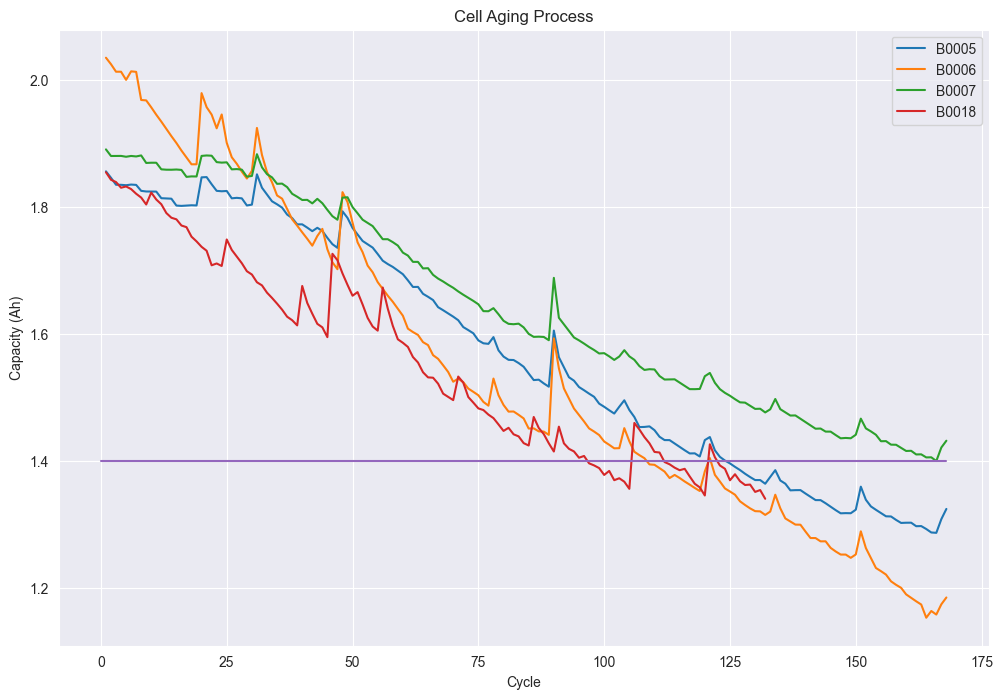

In [43]:
cell_capacity_1 = B0005_capacity
cell_capacity_2 = B0006_capacity
cell_capacity_3 = B0007_capacity
cell_capacity_4 = B0018_capacity
plot_df_1 = cell_capacity_1.loc[(cell_capacity_1['cycle']>=1),['cycle','capacity']]
plot_df_2 = cell_capacity_2.loc[(cell_capacity_2['cycle']>=1),['cycle','capacity']]
plot_df_3 = cell_capacity_3.loc[(cell_capacity_3['cycle']>=1),['cycle','capacity']]
plot_df_4 = cell_capacity_4.loc[(cell_capacity_4['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df_1['cycle'], plot_df_1['capacity'], label='B0005')
plt.plot(plot_df_2['cycle'], plot_df_2['capacity'], label='B0006')
plt.plot(plot_df_3['cycle'], plot_df_3['capacity'], label='B0007')
plt.plot(plot_df_4['cycle'], plot_df_4['capacity'], label='B0018')
#Draw threshold
plt.plot([0.,len(cell_capacity_1)], [1.4, 1.4])
plt.ylabel('Capacity (Ah)')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('Cycle')
plt.legend()
plt.title('Cell Aging Process')

# Defining Training and Validation Dataset

In [21]:
#Extract nsample data of battery's voltage, current and temperature for a specific cycle
def extract_cycle_VIT(batt, nsample, ncyl, features):
    nfeatures = len(features)
    out = batt.loc[batt['cycle']==ncyl, features]
    out = out.head(nsample)#out.sample(n = nsample)
    out = out.melt(ignore_index=True)
    out = out['value'].values.reshape(1, nfeatures*nsample, 1)
    return out

#Extract nsample data of battery's voltage, current and temperature for all cycles
def extract_VIT(batt, nsample, features):
    data = []
    temp_cyc = batt['cycle'].drop_duplicates(keep='first')
    for i in range(1, len(temp_cyc)):
        temp = extract_cycle_VIT(batt, nsample, i, features)
        data.append(temp)
    arr = np.array(data)
    return arr

#Set up training dataset of 3 batteries
def set_x_training_dataset(batt1, batt2, batt3):
    xTrain = np.append(batt1[0:len(batt1)-1], batt2[0:len(batt2)-1], axis=0)
    xTrain = np.append(xTrain, batt3[0:len(batt3)-1], axis=0)
    return xTrain

#Set up training label of 3 batteries
def set_y_training_dataset(batt1, batt2, batt3):
    yTrain = np.append(batt1, batt2, axis=0)
    yTrain = np.append(yTrain, batt3, axis=0)
    return yTrain

#Set up test dataset of 3 batteries
def set_x_test_dataset(batt):
    xTest = np.array(batt[0:len(batt)-1])
    return xTest

#Set up test label of 3 batteries
def set_y_test_dataset(batt):
    xTest = np.array(batt)
    return xTest


In [36]:
#Set sample to 10
nsample = 10

#Set required features to be loaded
features = ['voltage_measured', 
            'current_measured', 
            'temperature_measured', 
            #'current_charge', 
            #'voltage_charge', 
            'cycle']

nfeatures = len(features)

#Load VIT features of all batteries dataset
dt_B0005_VIT = extract_VIT(X_B0005_charge, nsample, features)
dt_B0006_VIT = extract_VIT(X_B0006_charge, nsample, features)
dt_B0007_VIT = extract_VIT(X_B0007_charge, nsample, features)
dt_B0018_VIT = extract_VIT(X_B0018_charge, nsample, features)

#Set up the training and test dataset
xTrain = set_x_training_dataset(dt_B0005_VIT, dt_B0006_VIT, dt_B0007_VIT)
xTest = set_x_test_dataset(dt_B0018_VIT)

#Set up the training and test label
yTrain = set_y_training_dataset(B0005_SOH, B0006_SOH, B0007_SOH)
yTest = set_y_test_dataset(B0018_SOH)


# Model Definition and Training

In [38]:
# Building the CNN model
input_shape = xTrain[1].shape
model = Sequential()
model.add(Conv2D(30, kernel_size=(1, 2), strides=(1, 1), input_shape=input_shape))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(1,2))
model.add(Conv2D(15, kernel_size=(1, 2),strides=(1, 1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(1,2))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1, 39, 30)         90        
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1, 39, 30)         0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 20, 30)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 19, 15)         915       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1, 19, 15)         0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 10, 15)        0         
 2D)                                                  

In [39]:
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [40]:
model.fit(xTrain,yTrain,epochs=500, batch_size=50, verbose=2)

Epoch 1/500
11/11 - 1s - loss: 21.2233 - 884ms/epoch - 80ms/step
Epoch 2/500
11/11 - 0s - loss: 6.0596 - 53ms/epoch - 5ms/step
Epoch 3/500
11/11 - 0s - loss: 1.8184 - 44ms/epoch - 4ms/step
Epoch 4/500
11/11 - 0s - loss: 0.4721 - 40ms/epoch - 4ms/step
Epoch 5/500
11/11 - 0s - loss: 0.3184 - 51ms/epoch - 5ms/step
Epoch 6/500
11/11 - 0s - loss: 0.2433 - 55ms/epoch - 5ms/step
Epoch 7/500
11/11 - 0s - loss: 0.2189 - 51ms/epoch - 5ms/step
Epoch 8/500
11/11 - 0s - loss: 0.2032 - 48ms/epoch - 4ms/step
Epoch 9/500
11/11 - 0s - loss: 0.1882 - 51ms/epoch - 5ms/step
Epoch 10/500
11/11 - 0s - loss: 0.1822 - 46ms/epoch - 4ms/step
Epoch 11/500
11/11 - 0s - loss: 0.1714 - 45ms/epoch - 4ms/step
Epoch 12/500
11/11 - 0s - loss: 0.1644 - 47ms/epoch - 4ms/step
Epoch 13/500
11/11 - 0s - loss: 0.1538 - 46ms/epoch - 4ms/step
Epoch 14/500
11/11 - 0s - loss: 0.1440 - 44ms/epoch - 4ms/step
Epoch 15/500
11/11 - 0s - loss: 0.1333 - 47ms/epoch - 4ms/step
Epoch 16/500
11/11 - 0s - loss: 0.1239 - 54ms/epoch - 5ms/ste

Epoch 131/500
11/11 - 0s - loss: 0.0024 - 45ms/epoch - 4ms/step
Epoch 132/500
11/11 - 0s - loss: 0.0024 - 44ms/epoch - 4ms/step
Epoch 133/500
11/11 - 0s - loss: 0.0034 - 38ms/epoch - 3ms/step
Epoch 134/500
11/11 - 0s - loss: 0.0026 - 40ms/epoch - 4ms/step
Epoch 135/500
11/11 - 0s - loss: 0.0030 - 46ms/epoch - 4ms/step
Epoch 136/500
11/11 - 0s - loss: 0.0024 - 40ms/epoch - 4ms/step
Epoch 137/500
11/11 - 0s - loss: 0.0024 - 40ms/epoch - 4ms/step
Epoch 138/500
11/11 - 0s - loss: 0.0024 - 40ms/epoch - 4ms/step
Epoch 139/500
11/11 - 0s - loss: 0.0029 - 41ms/epoch - 4ms/step
Epoch 140/500
11/11 - 0s - loss: 0.0025 - 43ms/epoch - 4ms/step
Epoch 141/500
11/11 - 0s - loss: 0.0026 - 39ms/epoch - 4ms/step
Epoch 142/500
11/11 - 0s - loss: 0.0027 - 44ms/epoch - 4ms/step
Epoch 143/500
11/11 - 0s - loss: 0.0025 - 46ms/epoch - 4ms/step
Epoch 144/500
11/11 - 0s - loss: 0.0025 - 44ms/epoch - 4ms/step
Epoch 145/500
11/11 - 0s - loss: 0.0024 - 42ms/epoch - 4ms/step
Epoch 146/500
11/11 - 0s - loss: 0.0024 

11/11 - 0s - loss: 0.0031 - 41ms/epoch - 4ms/step
Epoch 260/500
11/11 - 0s - loss: 0.0030 - 42ms/epoch - 4ms/step
Epoch 261/500
11/11 - 0s - loss: 0.0021 - 42ms/epoch - 4ms/step
Epoch 262/500
11/11 - 0s - loss: 0.0020 - 42ms/epoch - 4ms/step
Epoch 263/500
11/11 - 0s - loss: 0.0023 - 40ms/epoch - 4ms/step
Epoch 264/500
11/11 - 0s - loss: 0.0022 - 41ms/epoch - 4ms/step
Epoch 265/500
11/11 - 0s - loss: 0.0025 - 43ms/epoch - 4ms/step
Epoch 266/500
11/11 - 0s - loss: 0.0028 - 39ms/epoch - 4ms/step
Epoch 267/500
11/11 - 0s - loss: 0.0022 - 46ms/epoch - 4ms/step
Epoch 268/500
11/11 - 0s - loss: 0.0022 - 40ms/epoch - 4ms/step
Epoch 269/500
11/11 - 0s - loss: 0.0026 - 41ms/epoch - 4ms/step
Epoch 270/500
11/11 - 0s - loss: 0.0022 - 39ms/epoch - 4ms/step
Epoch 271/500
11/11 - 0s - loss: 0.0048 - 41ms/epoch - 4ms/step
Epoch 272/500
11/11 - 0s - loss: 0.0081 - 44ms/epoch - 4ms/step
Epoch 273/500
11/11 - 0s - loss: 0.0044 - 43ms/epoch - 4ms/step
Epoch 274/500
11/11 - 0s - loss: 0.0027 - 41ms/epoch -

Epoch 388/500
11/11 - 0s - loss: 0.0026 - 45ms/epoch - 4ms/step
Epoch 389/500
11/11 - 0s - loss: 0.0034 - 50ms/epoch - 5ms/step
Epoch 390/500
11/11 - 0s - loss: 0.0021 - 52ms/epoch - 5ms/step
Epoch 391/500
11/11 - 0s - loss: 0.0021 - 49ms/epoch - 4ms/step
Epoch 392/500
11/11 - 0s - loss: 0.0019 - 43ms/epoch - 4ms/step
Epoch 393/500
11/11 - 0s - loss: 0.0019 - 45ms/epoch - 4ms/step
Epoch 394/500
11/11 - 0s - loss: 0.0020 - 42ms/epoch - 4ms/step
Epoch 395/500
11/11 - 0s - loss: 0.0018 - 44ms/epoch - 4ms/step
Epoch 396/500
11/11 - 0s - loss: 0.0025 - 45ms/epoch - 4ms/step
Epoch 397/500
11/11 - 0s - loss: 0.0020 - 43ms/epoch - 4ms/step
Epoch 398/500
11/11 - 0s - loss: 0.0022 - 45ms/epoch - 4ms/step
Epoch 399/500
11/11 - 0s - loss: 0.0046 - 41ms/epoch - 4ms/step
Epoch 400/500
11/11 - 0s - loss: 0.0041 - 36ms/epoch - 3ms/step
Epoch 401/500
11/11 - 0s - loss: 0.0019 - 39ms/epoch - 4ms/step
Epoch 402/500
11/11 - 0s - loss: 0.0045 - 40ms/epoch - 4ms/step
Epoch 403/500
11/11 - 0s - loss: 0.0024 

# Prediction

In [41]:
yPredict = model.predict(xTest) # predictions on test data

##Calculate the prediction error
#Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(yTest, yPredict)
print(mape)

#Mean Absolute Error
mae = mean_absolute_error(yTest, yPredict)
print(mae)

#Root Mean Square
rms = np.sqrt(mean_squared_error(yTest, yPredict))
print(rms)

5/5 [==============================] - 0s 3ms/step
0.02976328779401424
0.023985523253144937
0.032513552354911754


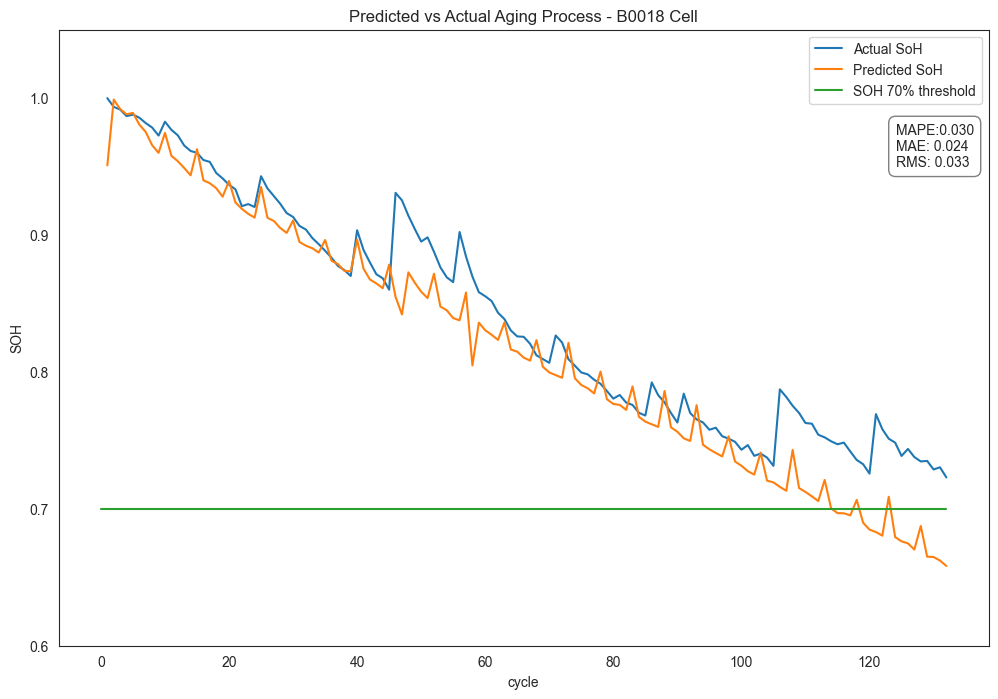

In [42]:
#Plotting the prediction result against the measured SOH
cell_cycle = B0018_capacity['cycle']
cell_name = 'B0018'
feature_name = 'V'
file_name = cell_name + ' - ' + feature_name + '.png'

fig, ax = plt.subplots(1, figsize=(12, 8))
sns.set_style("white")

#Plot predicted and actual SOH
ax.plot(cell_cycle, yTest, label='Actual SoH')
ax.plot(cell_cycle, yPredict, '-', label='Predicted SoH')

#Insert MAPE, MAE, RMS
ax.text(len(cell_cycle)* 0.94, 0.95, f'MAPE:{mape:.3f}\nMAE: {mae:.3f}\nRMS: {rms:.3f}',
        bbox={'edgecolor':'black', 'boxstyle': 'round, pad=0.5', 'facecolor': 'white', 'alpha': 0.5, 'pad': 3})

#Draw threshold
ax.plot([0.,len(cell_cycle)], [0.70, 0.70], label='SOH 70% threshold')

#Draw graph
ax.set_ylabel('SOH')
adf = fig.gca().get_xaxis().get_major_formatter()
ax.set_xlabel('cycle')
ax.legend()
ax.set_ylim([0.60, 1.05])
ax.set_title('Predicted vs Actual Aging Process - ' + cell_name + ' Cell')

#Save graph
plt.savefig(file_name)